# Causal Machine Learning for Treatment Effect Estimation

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR
from significance import *
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary import data_processing, doubly_robust, visualise, visualise_ites_proba, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition, run_model_class, multicol
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [2]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of minor social activities,involved with or without preferences in last 3 days. 
EXPOSURE_THRESHOLD = 1#3 # SET TO 3

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 120 #240
PERIOD_MAX = 240 #360

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = False

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = False

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True


TREATMENT = 'is2r' # (days of Social activities)
OUTCOME = 'in5a' 

Having set the desired parameters, we will now read in the data.

In [3]:
file = "data/dutch_LTCF_all.csv"

# read data
df = pd.read_csv(file)
print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

Treatment before processing 25034


In [4]:
#example how to created new variable is2r.cat from is2r
# new variable is2r.cat will take values 1 (if is2r=1 or 3 or 4) or 0 (if is2r=0 or is2r=2)
df['is2r.cat']=df['is2r'].apply(lambda x: 0 if(x==0 or x==2) else 1 if (x==1 or x==3 or x==4) else None)
# Control
pd.crosstab(df['is2r'],df['is2r.cat'])

is2r.cat,0.0,1.0
is2r,,
0.0,11709,0
1.0,0,2263
2.0,2032,0
3.0,0,5951
4.0,0,17051


In [5]:
df

,Unnamed: 0,Clientid,Snapshotid,qrt,qrt2,Clientid_original,ClientDepartmentcode,facility_id_first,facility_id,Facility_country,...,rugclin,HUI3,HUI3p1,Ndisorders,sFI_corrected,sFI_corrected_long,N05A,N06A,N06D,is2r.cat
0,1,42,NaN,1,1,NaN,NaN,42420220.0,42420220.0,1.0,...,7,NaN,NaN,1,0.148571,0.147429,0.0,0.0,0.0,NaN
1,2,43,NaN,1,1,NaN,NaN,75750563.0,75750563.0,1.0,...,4,NaN,NaN,2,0.449143,0.396457,0.0,0.0,0.0,NaN
2,3,82,NaN,2,1,NaN,NaN,42420220.0,42420220.0,1.0,...,2,0.299840,0.299840,0,0.327857,0.286389,0.0,0.0,0.0,0.0
3,4,82,NaN,1,2,NaN,NaN,42420220.0,42420220.0,1.0,...,2,NaN,NaN,0,0.302963,0.273824,0.0,0.0,0.0,NaN
4,5,83,NaN,1,1,NaN,NaN,42420220.0,42420220.0,1.0,...,5,NaN,NaN,1,0.143593,0.114029,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48137,48138,1825793914,6087.0,1,1,6086.0,246.0,NaN,NaN,NaN,...,7,0.795090,0.795090,0,0.093321,0.090917,NaN,NaN,NaN,1.0
48138,48139,3998986670,13331.0,1,1,13330.0,246.0,NaN,NaN,NaN,...,4,-0.216377,-0.216377,3,0.410231,0.391059,1.0,NaN,NaN,1.0
48139,48140,6135579548,20453.0,1,1,20452.0,246.0,NaN,NaN,NaN,...,3,NaN,NaN,3,0.544643,0.476667,NaN,NaN,NaN,1.0
48140,48141,8479471735,28266.0,1,1,28265.0,246.0,NaN,NaN,NaN,...,6,0.770809,0.770809,2,0.168929,0.145278,NaN,1.0,NaN,1.0


## Create "Fake" Discrete Outcome to Represent Mortality or Hospitalization

In [6]:
# REMOVE THIS, JUST TO SHOW THAT THE CODE RUNS
#df['hosp'] = np.random.choice([0,1], size = len(df))

<AxesSubplot:xlabel='in5a', ylabel='Count'>

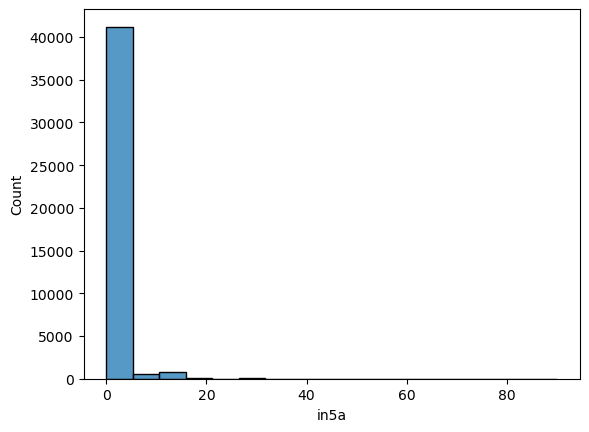

In [7]:
sns.histplot(df['in5a'])

In [8]:
df['in5a'].unique()

array([ 0., nan,  4., 14.,  2.,  1., 15., 43., 20.,  3., 11., 25.,  9.,
       10., 16.,  7., 12., 21., 23., 17., 30.,  5.,  8., 13., 27.,  6.,
       19., 18., 35., 31., 60., 40., 28., 26., 49., 22., 55., 29., 50.,
       77., 52., 90., 38., 47., 51., 24., 83., 39., 74., 67., 33., 58.,
       44., 54., 53., 45., 85., 75., 36., 34., 42., 76., 62.])

In [9]:
df = df[(df['in5a']==0)|(df['in5a']==1)]

In [10]:
to_discrete = lambda x: 1 if x >= 1 else 0
df['is2r'] = df['is2r'].apply(to_discrete)

In [11]:
df['is2r']#.describe()

0        0
1        0
2        0
3        0
4        0
        ..
48137    1
48138    1
48139    1
48140    1
48141    1
Name: is2r, Length: 40596, dtype: int64

In [12]:
# get number of classes
NUM_CLASSES = len(df[OUTCOME].dropna().unique())

## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [13]:
# list relevant confounders
confounders = ['ia4',  'ii1c', 'ii1d', 'ii1e', 
                        'ii1f', 'ii1h', 'ii1p',  
                        'ii1n', 'ii1o', 'ii1i', 'ii1w', 'if1d', 'cADL', 'sPAIN', 'sCPS', 'iA2', 'sAGE_cat']

#also convert values to list for ease of processing later on 
#listed_val_based_con = [key for key, value in value_based_confounders.items()]
#confounders = confounders =+ Listed_val_based_confounders
        
# ADD VALUE BASED CLINICAL INDICATIONS, E.G. {'sDRS' : [3,4]}

# list of other relevant variables
relevant_vars = ['iA9', 'Clientid', TREATMENT, OUTCOME]

print(len(confounders)) 


17


Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [14]:
code = 'iA2'
print(encoding[(code).lower()])

Gender


Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

Having processed the contra-indications, we can now select the necessary columns in the data.

In [15]:
# df = df[list(confounders + relevant_vars)]
# print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

In [16]:
df = df[list(confounders + relevant_vars)]
print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

Treatment after selecting covariates 25537


In [17]:
df[list(confounders + relevant_vars)]

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,if1d,cADL,sPAIN,sCPS,iA2,sAGE_cat,iA9,Clientid,is2r,in5a
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,90,2005-06-13,42,0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,75,2006-06-09,43,0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,2.0,2.0,95,2006-01-13,82,0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,2.0,2.0,95,2005-06-06,82,0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,NaN,0.0,NaN,1.0,80,2005-06-13,83,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48137,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,90,2022-11-10,1825793914,1,0.0
48138,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,5.0,2.0,85,2022-11-10,3998986670,1,0.0
48139,NaN,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,4.0,1.0,70,2022-11-10,6135579548,1,0.0
48140,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,75,2022-11-10,8479471735,1,0.0


In [18]:
#df['iA2']

In [19]:
# remove duplicated cols if necessary
df = df.loc[:,[True if i == False else False for i in df.T.index.duplicated(keep='first')]] 

### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [20]:
# get number of assesments
counter = lambda x: len(df[df['Clientid']==x])

# count number of items
df['num_assesments'] = df['Clientid'].apply(counter)

Let us select only observations with more than 2 assesments. 

In [21]:
# get number of assesments higher than 1
df = df[df['num_assesments']>=2]

print(f'{len(df)} observations remaining.')
print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

37008 observations remaining.
Treatment after selecting on number of assesments 0


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [22]:
# convert column to datetime 
df['iA9'] = pd.to_datetime(df['iA9']) 
# sort values by ID and date
df = df.sort_values(by = ['Clientid', 'iA9'])
# drop nans on dates of assesment
df = df[df['iA9'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [23]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('Clientid').apply(
    lambda x: x[x['iA9'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [24]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [25]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['Clientid'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['Clientid'] == client_id].sort_values('iA9')
        client_dates = client_rows['iA9'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['iA9'] == baseline_date]
            followup_row = client_rows[client_rows['iA9'] == followup_date]

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [26]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 7515 items completed...
2000 of 7515 items completed...
3000 of 7515 items completed...
4000 of 7515 items completed...
5000 of 7515 items completed...
6000 of 7515 items completed...
7000 of 7515 items completed...
7515 of 7515 items completed...
Completed.
Treatment after processing 0


### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [27]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
df['treatment'] = df[TREATMENT].apply(binary)  
df = df.drop(columns = [TREATMENT])

In [28]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])
df.head(3)

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,sAGE_cat,iA9,Clientid,in5a,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95,2005-06-06,82,0.0,2,0.0,0.0,2005-06-06,2006-01-13,0
1,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,85,2005-06-06,132,0.0,2,0.0,0.0,2005-06-06,2005-09-08,0
2,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80,2005-06-06,179,0.0,2,0.0,0.0,2005-06-06,2005-09-08,0


### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [29]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

10119

### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [30]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [31]:
if REMOVE_MULTI_COL:
    df = multicol(df, CORRELATION_THRESHOLD)

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [32]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [33]:
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

In [34]:
# treatment = TREATMENT#'is2b' # (minutes or days of social activity)
# target = #'in5a' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [35]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)

        

In [36]:
covar_names

['Marital Status',
 'Alzheimers disease',
 'Dementia other than Alzheimers disease',
 'Hemiplegia',
 'Multiple sclerosis',
 'Parkinsons disease',
 'Schizophrenia',
 'Anxiety',
 'Depression',
 'Quadriplegia',
 'Bipolar disorder',
 'Loneliness: indicates feelings of loneliness',
 'ADL CAP',
 'sPAIN',
 'sCPS Cognitive Performance Scale 0-6 range-Morris 1991',
 'Gender',
 'sAGE_cat',
 'OutcomeT0']

In [37]:
# quick model
clf = RandomForestClassifier()

# get data
X = df.drop(columns = ['OutcomeT1'])
y = df['OutcomeT1']

# train model
clf.fit(X, y)
importances = clf.feature_importances_
feature_names = [] #X.columns

# get col names
for col in X.columns:
    try:
        feature_names.append(encoding[(col).lower()])
    except:
        feature_names.append(col)

# get feature importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)

feature_importances

,feature,importance
17,OutcomeT0,0.165564
16,sAGE_cat,0.141745
0,Marital Status,0.119985
13,sPAIN,0.090614
14,sCPS Cognitive Performance Scale 0-6 range-Mor...,0.089951
12,ADL CAP,0.089086
2,Dementia other than Alzheimers disease,0.043615
1,Alzheimers disease,0.041661
11,Loneliness: indicates feelings of loneliness,0.037618
15,Gender,0.036394


### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestClassifier()``.

In [38]:
model0 = RandomForestClassifier()
model1 = RandomForestClassifier()

In [39]:
model = model0

In [40]:
# File path for the Excel file
excel_file = f'data/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [41]:
# call your data file here
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [42]:
metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, ites_test_proba = run_model_class(n_bootstraps = 30, file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, intervention = TREATMENT, include_propensity = PROPENSITY, outcome = OUTCOME, machine = "RandomForest", num_iter = 1)

DF lenght after undersampling: 13950
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.01, 95% CI: [-1.95, 1.97]


We can now examine the performance of the model by calling ``metrics``.

In [43]:
#metrics

In [44]:
confidence_interval(data=ites_test)

(6.814996010671027e-06, 0.006442486329679045)


In [45]:
significance(data=ites_test)

T-statistic: 1.9649673975407982
P-value: 0.04951709435082195
Result is statistically significant


We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

In [46]:
machine = "RandomForest"
# visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

ATE 0.0032246506628448583


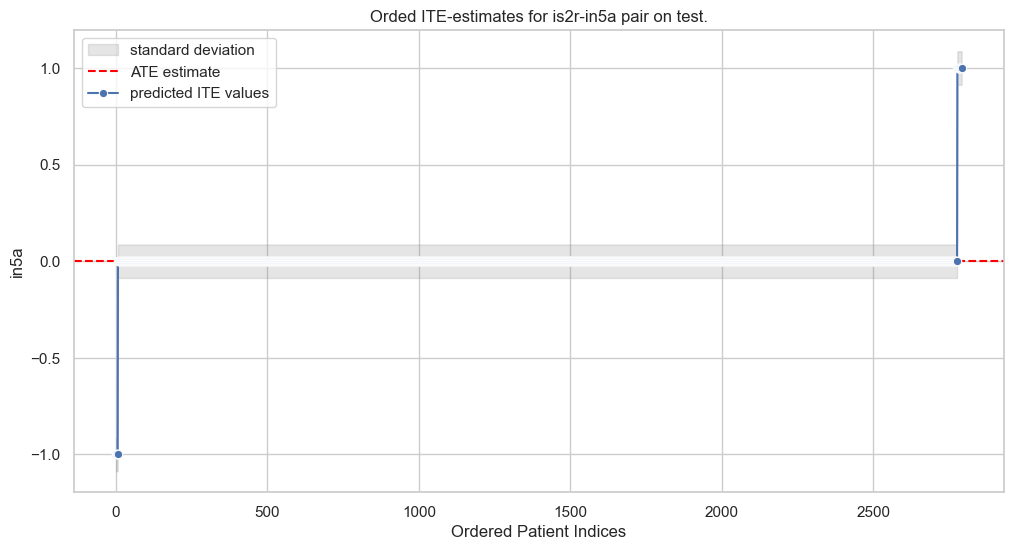

In [47]:
visualise_ites(ites_test, machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE 0.005645667174478


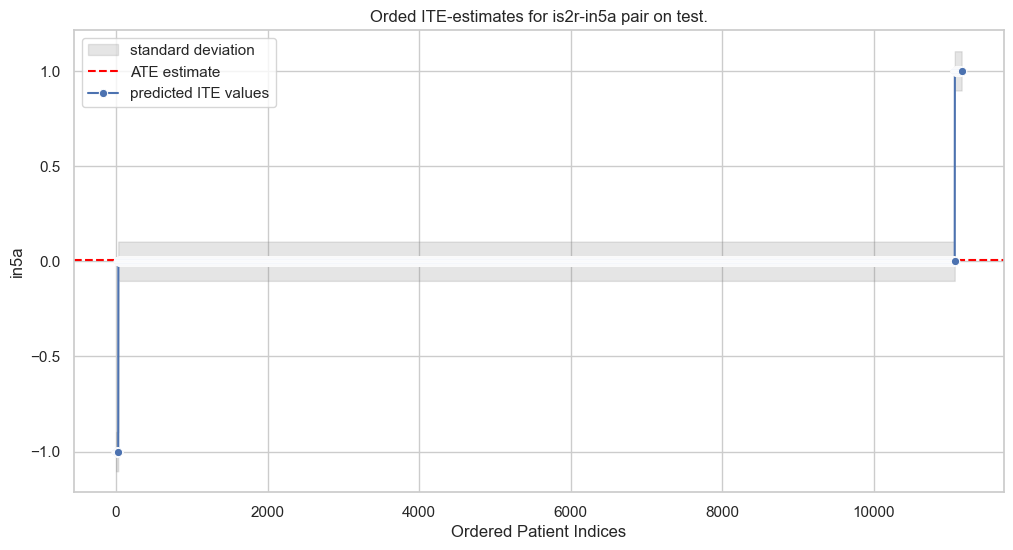

In [48]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestClassifier()``
- ``MLPClassifier()``
- ``LogisticRegression()``

RandomForestClassifier()
DF lenght after undersampling: 13950
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.01, 95% CI: [-1.95, 1.97]
ATE 0.0010748835542816195


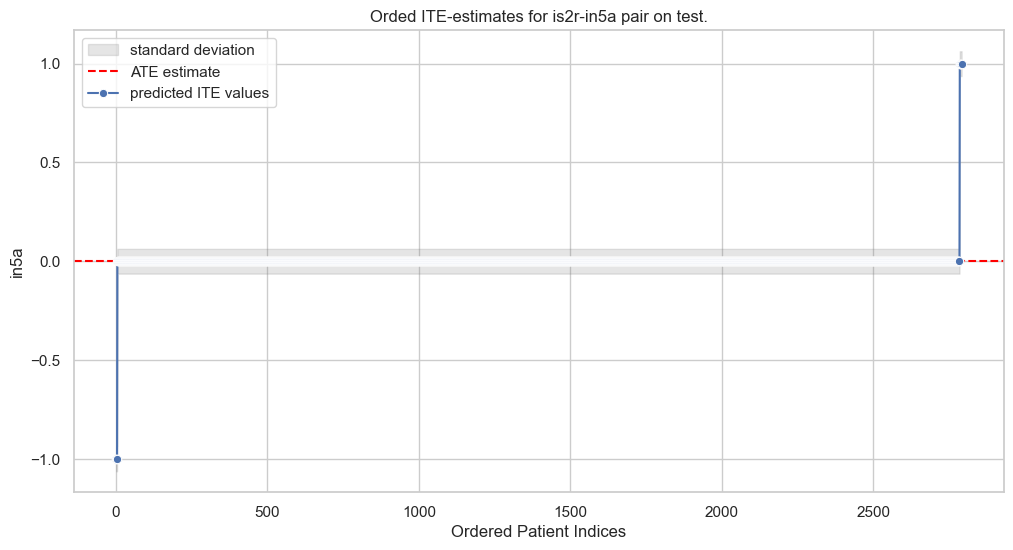

Probabilistic ATE 0.003038511332176683


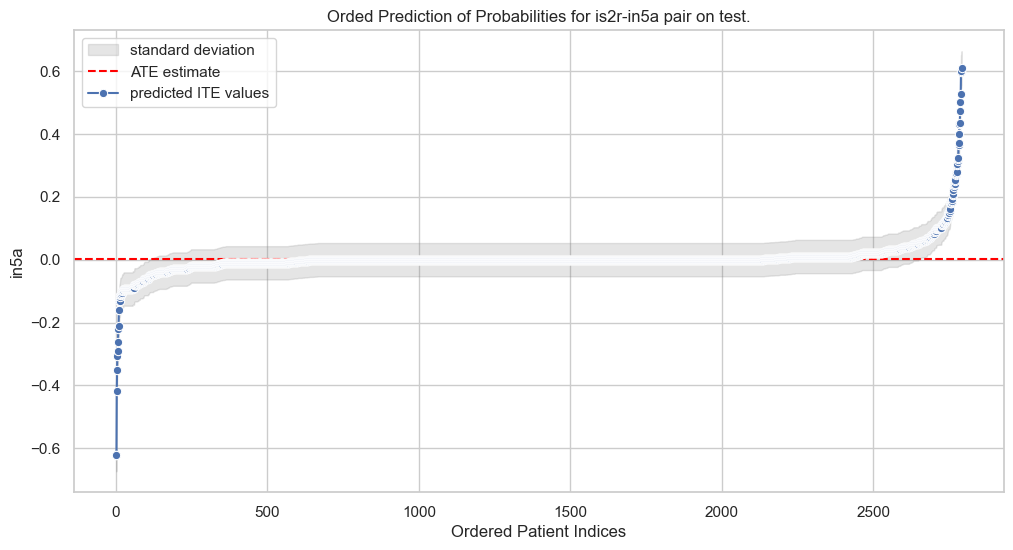

       RandomForestClassifier()
ACC_C                  0.994785
ACC_T                  0.987154
(-0.0012552842311718165, 0.0034050513397350553)
T-statistic: 0.9045045619240286
P-value: 0.36580601103210686
Result is not significant
MLPClassifier()
DF lenght after undersampling: 13950
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
ATE: 0.00, 95% CI: [-1.96, 1.96]
ATE -0.00035829451809387314


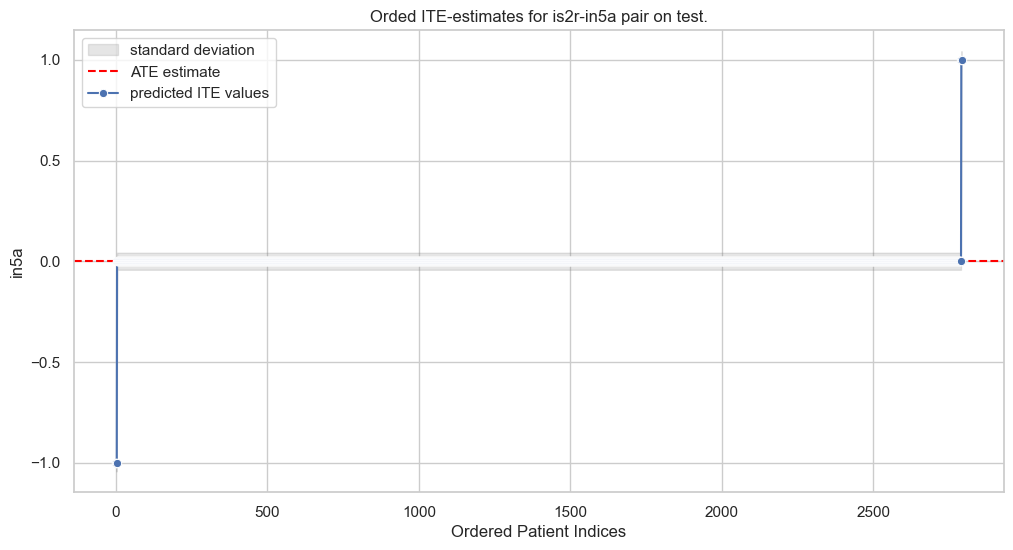

Probabilistic ATE -3.043929905544662e-05


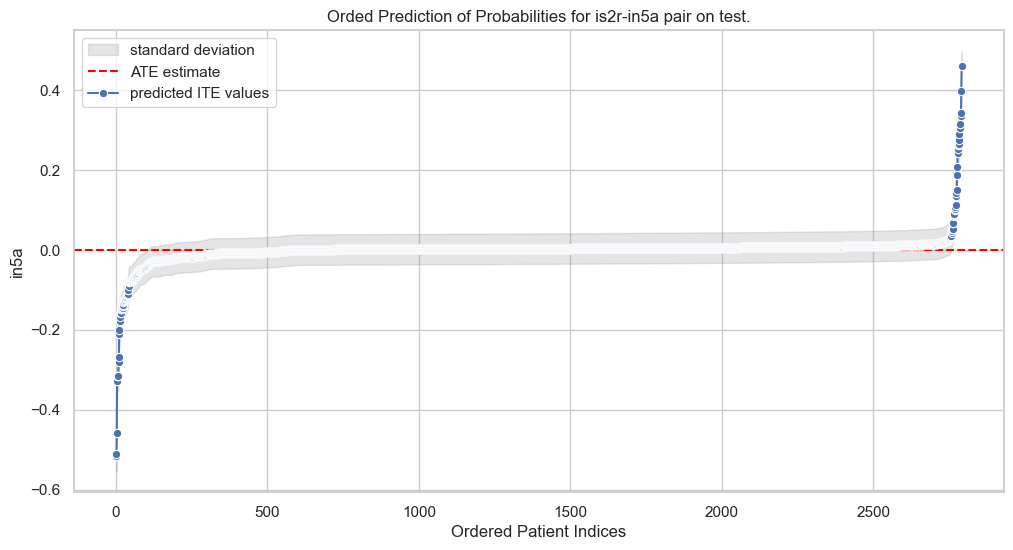

       MLPClassifier()
ACC_C         0.984355
ACC_T         0.985672
(-0.0019294673411126952, 0.0012128783049249491)
T-statistic: -0.44714949264067366
P-value: 0.6548018356724405
Result is not significant
DecisionTreeClassifier()
DF lenght after undersampling: 13950
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
ATE: 0.01, 95% CI: [-1.95, 1.97]
ATE 0.01791472590469366


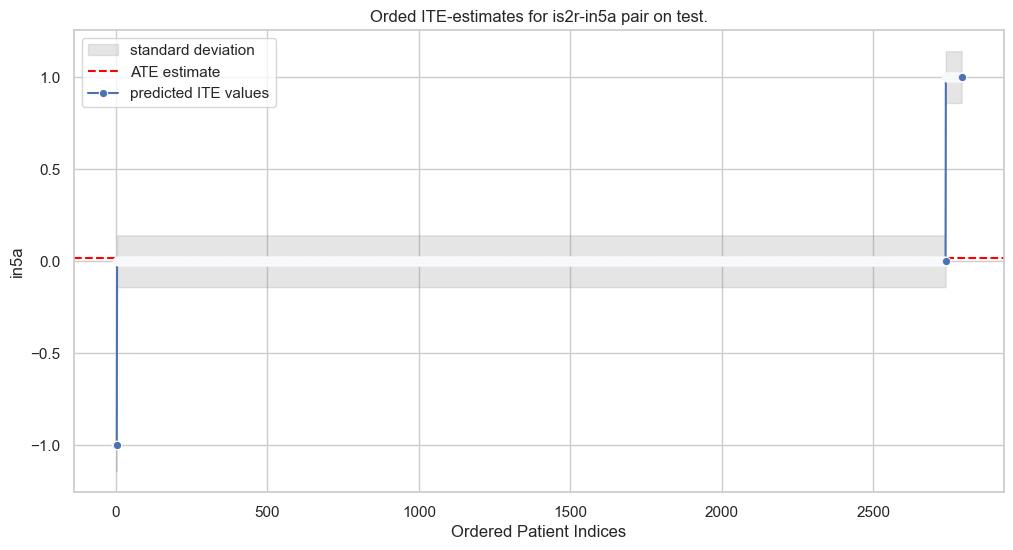

Probabilistic ATE 0.012944264342550665


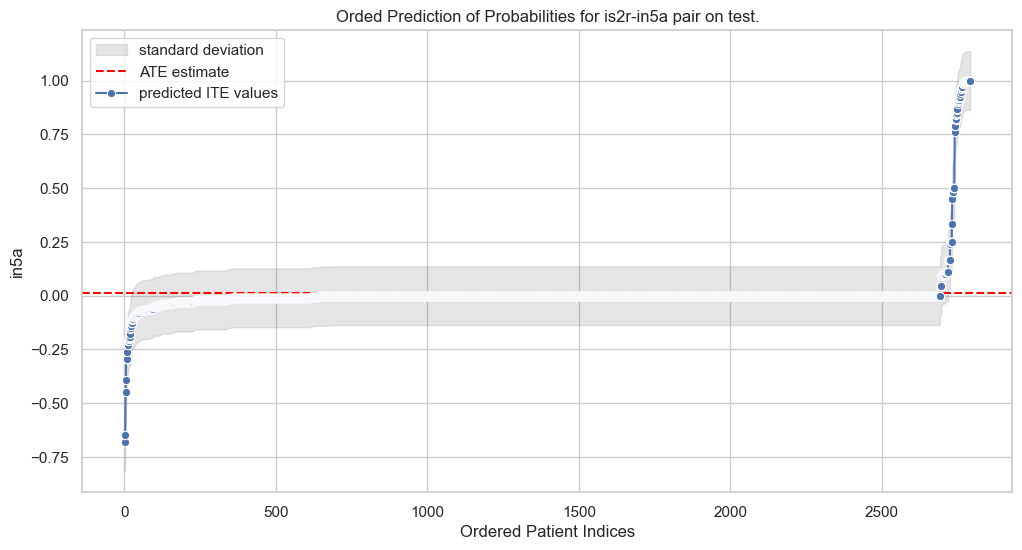

       DecisionTreeClassifier()
ACC_C                  0.988266
ACC_T                  0.976779
(0.012698611367417102, 0.023130840441970217)
T-statistic: 6.734410504629149
P-value: 1.9910053870077434e-11
Result is statistically significant
AdaBoostClassifier()
DF lenght after undersampling: 13950
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
ATE: 0.00, 95% CI: [-1.96, 1.96]
ATE 0.004657828735220351


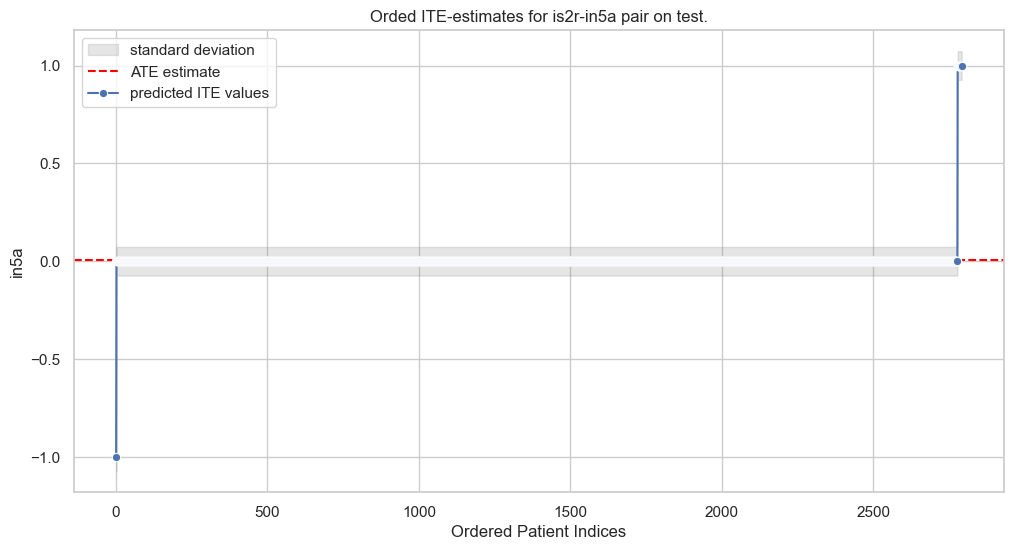

Probabilistic ATE 0.4505174215192865


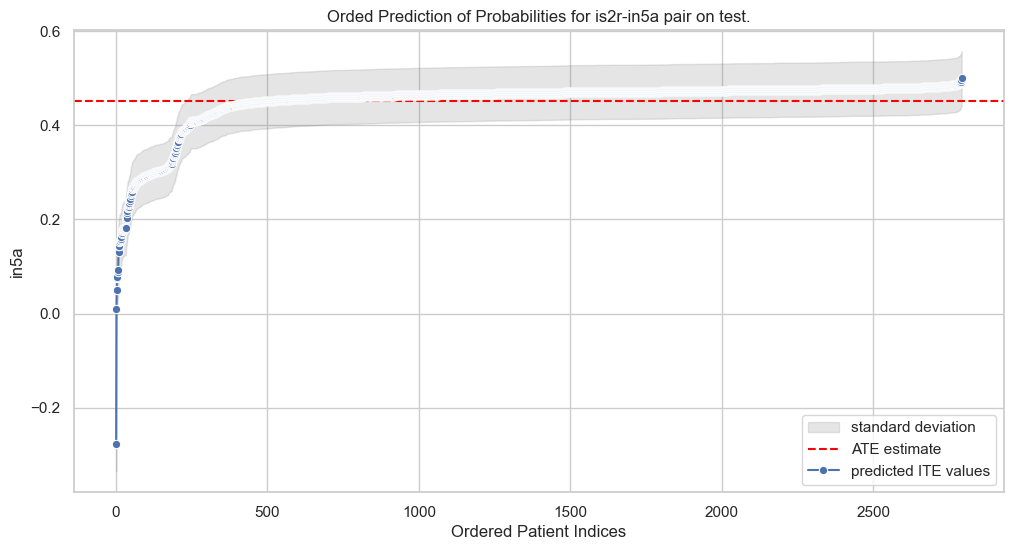

       AdaBoostClassifier()
ACC_C              0.994785
ACC_T              0.980237
(0.0019418785746498288, 0.007373778895790873)
T-statistic: 3.3627784600838613
P-value: 0.0007820311607345696
Result is statistically significant
GradientBoostingClassifier()
DF lenght after undersampling: 13950
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
ATE: 0.01, 95% CI: [-1.95, 1.97]
ATE 0.006091006807595844


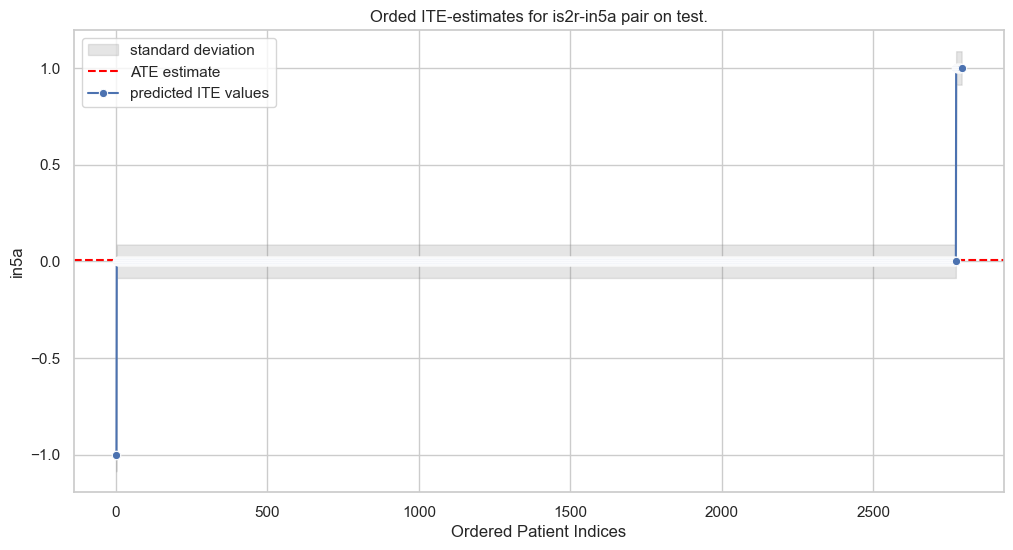

Probabilistic ATE 0.004408893233788493


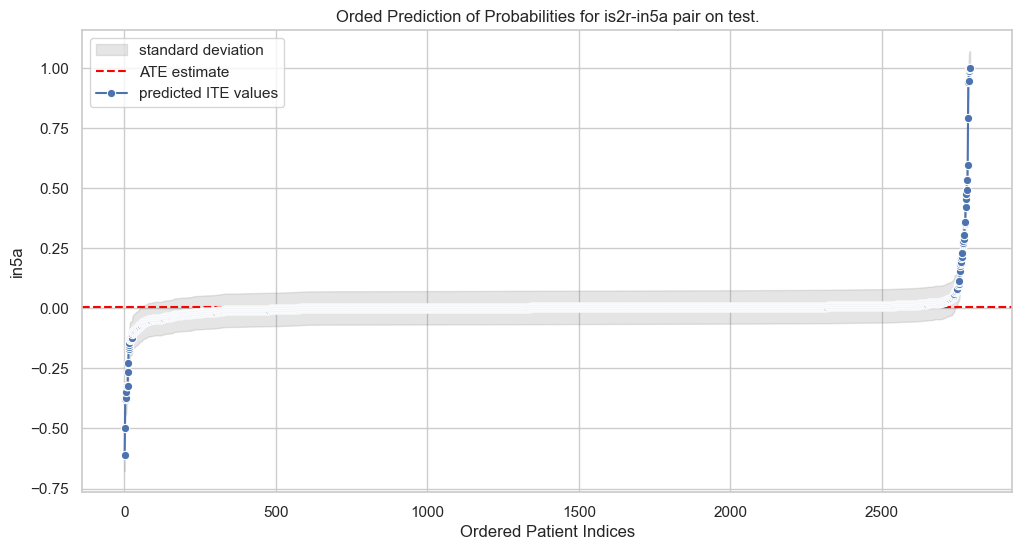

       GradientBoostingClassifier()
ACC_C                      0.989570
ACC_T                      0.981225
(0.002878893894176691, 0.009303119721014996)
T-statistic: 3.7182177411594868
P-value: 0.00020458119538114956
Result is statistically significant
ExtraTreesClassifier()
DF lenght after undersampling: 13950
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.01, 95% CI: [-1.95, 1.97]
ATE 0.0025080616266571123


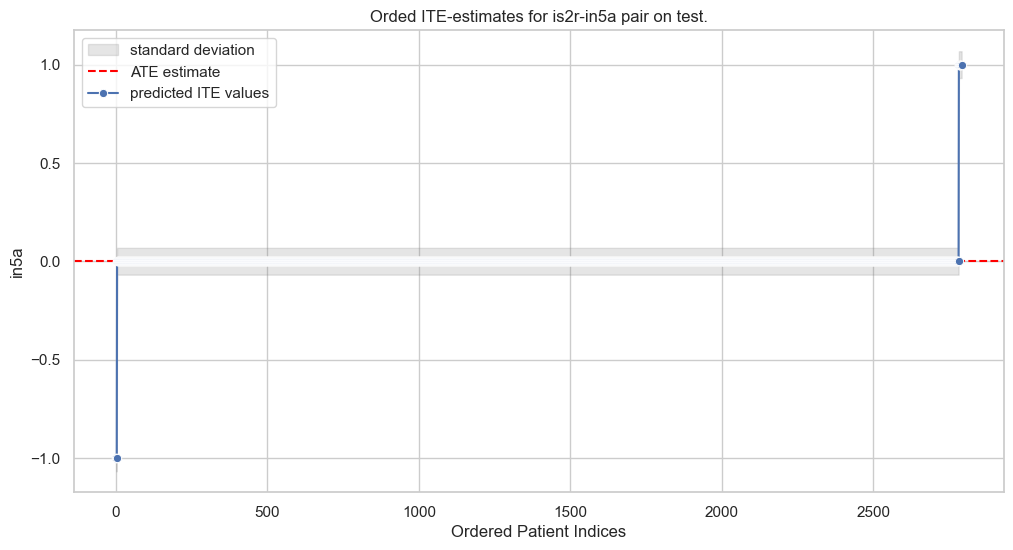

Probabilistic ATE 0.002252666218668099


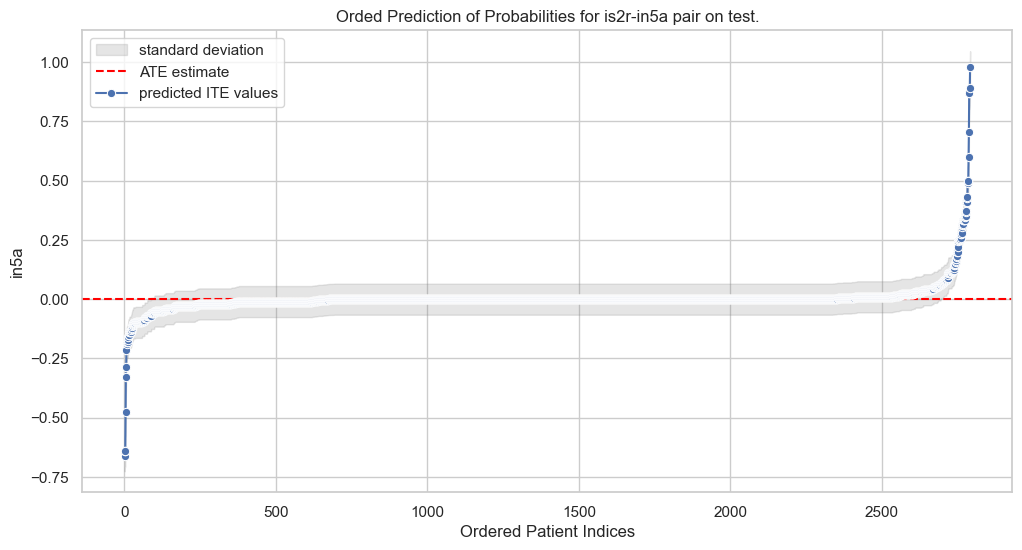

       ExtraTreesClassifier()
ACC_C                0.993481
ACC_T                0.987154
(-2.375786525945188e-05, 0.0050398811185736764)
T-statistic: 1.9424149037272032
P-value: 0.05218739331580361
Result is not significant
LogisticRegression()
DF lenght after undersampling: 13950
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
ATE: -0.00, 95% CI: [-1.96, 1.96]
ATE 0.0010748835542816195


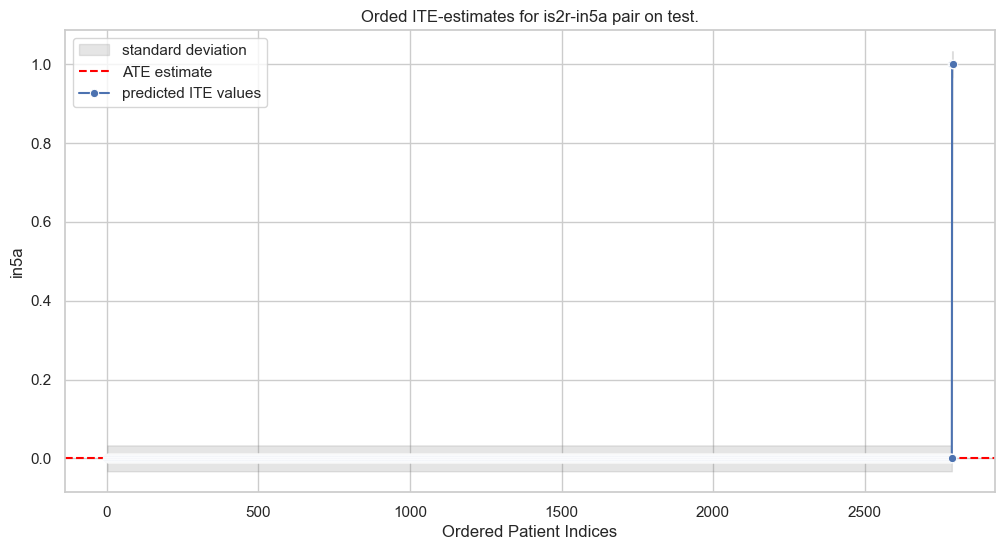

Probabilistic ATE 0.007667852415207197


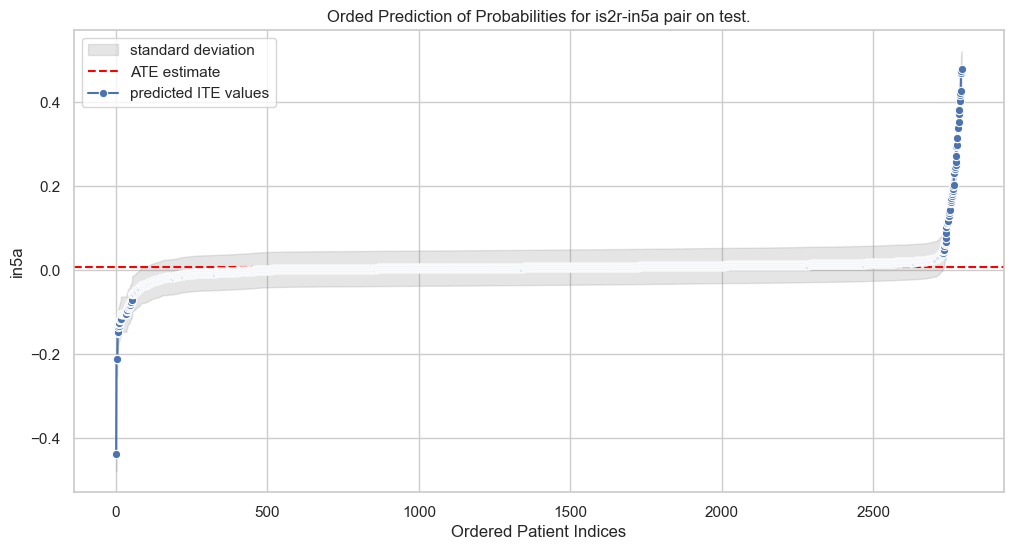

       LogisticRegression()
ACC_C              0.988266
ACC_T              0.988142
(-0.0001415310094143626, 0.0022912981179776014)
T-statistic: 1.7326719482765145
P-value: 0.08326449684936393
Result is not significant


In [49]:
model_lst = [(RandomForestClassifier(),RandomForestClassifier()), 
            (MLPClassifier(), MLPClassifier()), (DecisionTreeClassifier(), DecisionTreeClassifier()),
             (AdaBoostClassifier(), AdaBoostClassifier()), (GradientBoostingClassifier(), GradientBoostingClassifier()),
             (ExtraTreesClassifier(),ExtraTreesClassifier()),(LogisticRegression(), LogisticRegression())]

for model1, model2 in model_lst:
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, ites_test_proba = run_model_class(n_bootstraps = 30, file = FILE, intervention = TREATMENT, outcome = OUTCOME, include_propensity = PROPENSITY, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    #print("Probabilitiy of Hospitalization: ")
    visualise_ites_proba(ites_test_proba, machine = machine, intervention = TREATMENT, target = OUTCOME)
    print(metrics)
    confidence_interval(data=ites_test)
    significance(data=ites_test)

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

Not included. Does not work with probabilistic outcomes.